The ODA leverages the periodic nature of the ommatidial lattice found in many compound eyes. By using the 2D Fourier Transform, the ODA eliminates spatial detail that is either much smaller or larger than the ommatidia. With that removed, the ommatidia are a lot simpler to detect.
# The Fourier Transform
The fourier transform decomposes any function or sequence of values into a sequence of sine functions with specific frequencies, amplitudes, and phases. The original function or sequence can often be recovered exactly using the inverse fourier transform. 
![FFT demo](https://upload.wikimedia.org/wikipedia/commons/2/2b/Fourier_series_and_transform.gif)

This allows for the detection and extraction of periodic components in signals and extends into arbitrarily many dimensions. As a result, we can use the 2D discrete form of the Fourier transform, the Fast Fourier Transform (FFT) and the its inverse (iFFT), to detect the frequency corresponding to the ommatidial diameters and filter out those far above and below. These are both available functions in the numpy.fft library.

For more information on the Fourier Transform see [this wikipedia page](https://en.wikipedia.org/wiki/Fourier_transform) and I highly recommend the following beatiful video by [3Blue1Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw):

In [1]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/r6sGWTCMz2k", width=600, height=400)

# Gratings
The sinusoidal elements of a 2D image are called gratings and, like the sine functions in a 1D FFT, these are represented by a frequency, amplitude, and phase. In addition, 2D gratings have an orientation on the 2D plane, referring to the angle perpendicular to the grating's wavefront.

In the 2D grating, the spatial frequency refers to the number of oscillations from dark to light per degree (measured in cycles/°) and the amplitude refers to the contrast between the brightest and darkest points (maximum of 1). In principal, any digital image can be exactly decomposed into a finite set of these gratings. For instance, see the animation below from [The Python Coding Book](https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/) of how you can increasingly approximate an image of the Big Ben with higher and higher spatial frequencies of different orientations. The final composite is equivalent to the original image.

In [2]:
IFrame(src="https://videopress.com/embed/Z9xWcJw4", width=600, height=400)

To explore what this means for the 2D FFT, here's a class to generate and display gratings. If it imports correctly, the code below should diplay 9 gratings with different spatial frequencies and contrasts. Each grating is assumed to occupy a 180° FOV, so a spatial frequency of 1 cycle/° would display 180 cycles (from dark to light) in the whole image. Contrast is defined as Michelson contrast, which represents the contrast between the darkest (A) and brightest points (B) as (A-B)/(A+B). 
### Playing with Gratings
I made a few functions to help us better understand gratings and how they can help us detect ommatidia. For example, below I use the class I defined called Grating, which can display gratings of all sorts. Below I import the module and print out the docstringfor this Grating class.

In [3]:
with open('how_to_demo_tools.py', 'r') as tools:
    exec(tools.read())

help(Grating)

Help on class Grating in module __main__:

class Grating(builtins.object)
 |  Grating(sf=1, tf=0, contrast=1, orientation=0, size=(1000, 1000), window=0.2, fov=180, phase=0, ioa=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sf=1, tf=0, contrast=1, orientation=0, size=(1000, 1000), window=0.2, fov=180, phase=0, ioa=None)
 |      Class for making a sinusoidal grating.
 |      
 |      
 |      Parameters
 |      ----------
 |      sf : float, default=1
 |          The number of oscillations from dark to light per degree 
 |          (in cycles/degree).
 |      tf : float, default=1
 |          The number of oscillations from dark to light per second 
 |          (in Hz) for a moving grating.
 |      contrast : float, default=1
 |          The Michelson contrast between the darkest and lightest values, 
 |          amounting to the amplitude of the sinusoidal component.
 |      orientation : float, default=0
 |          The 2D orientation of the grating, perpendicular to it

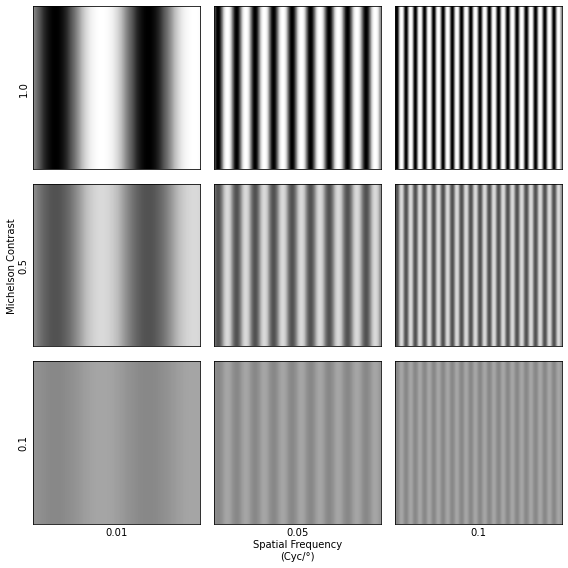

In [4]:
fig = plt.figure(figsize=(8,8))
i = 1
cs = np.array([.1, .5, 1])
# sfs = np.round(1/np.array([18, 36, 72]), 3)
sfs = np.array([.01, .05, .1])
for c in cs[::-1]:
    for sf in sfs:
        ax = plt.subplot(3, 3, i)
        g = Grating(sf=sf, contrast=c, window=None)
        g.fig = fig
        g.display(ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
        if (i - 1)%3 == 0:
            plt.ylabel(c)
        if i > 6:
            plt.xlabel(sf)
        if i == 4:
            plt.ylabel(f"Michelson Contrast\n{c}")
        if i == 8:
            plt.xlabel(f"{sf}\nSpatial Frequency\n(Cyc/°)")
        i += 1
#plt.suptitle("gratings vary by contrast and spatial frequency")
plt.tight_layout()
plt.show()

## Play!
Change the spatial frequency (sf), contrast, phase, and orientation of the grating below to see how it affects the display.

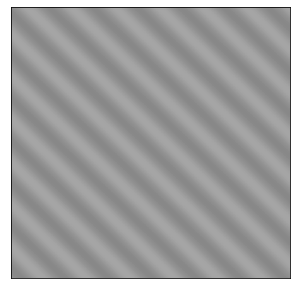

In [5]:
%matplotlib inline
g = Grating(sf=.05, contrast=.1, orientation=45, window=None)# sf in cycles/deg, orientation in deg
g.display()

## The 2D FFT measures grating parameters
We should be able to find the input grating parameters as output of the 2D FFT. First we need to measure how contrast varies as a function of spatial frequency, generating what's called the reciprocal image from the FFT. Let's use a function to plot the reciprocal image and measure some important information like the fundamental spatial frequency and orientation. Below is the docstring for this function. Note that we are now adding a gaussian window to reduce edge artifacts. 

In [6]:
help(process_reciprocal)

Help on function process_reciprocal in module __main__:

process_reciprocal(img, xvals, yvals, num_gratings=1)
    Process grating information from the reciprocal image of an input array.
    
    
    Parameters
    ----------
    img : np.ndarray, shape=(width, height)
        The image to process.
    xvals : array-like, shape=(width)
        The x-values for each column in img.
    yvals : array-like, shape=(height)
        The y-values for each row in img.
    num_gratings : int, default=1
        The number of fundamental frequencies to check for. 
        Half of the peaks to search for.



## Let's test it
Now we have a function that will plot the image and its reciprocal image and extract relevant information about the original image. We can test it with the block below. Feel free to change the input grating parameters (in all caps) and see how it affects the different output parameters. In particular, notice how the polar angle and radius of the red arrow in the reciprocal image corresponds to the grating spatial frequency and orientation.

max x-frequencies=	[-0.14985  0.14985]
max y-frequencies=	[-0.26085  0.26085]
spatial frequency=	[0.30082843 0.30082843]
orientation=		[-119.87599269   60.12400731]


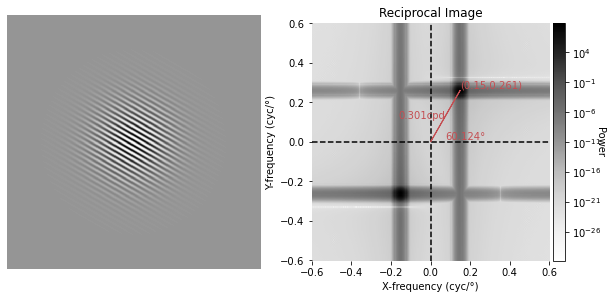

In [7]:
%matplotlib inline
#choose sf, contrast, and orientation of the grating
SF=.3           # cyc/deg
CONTRAST=1      # Michelson (max=1)
ORIENTATION=60  # deg
g = Grating(sf=SF, contrast=CONTRAST, orientation=ORIENTATION, window=.1)
process_reciprocal(g.img, g.x, g.y, num_gratings=1)

## Gratings combine independently
You can do the same analysis for multiple combine gratings, simply look for as many peaks as components. 
### See what happens when you combine two gratings:

max x-frequencies=	[ 0.0999  -0.0999  -0.14985  0.14985]
max y-frequencies=	[ 0.       0.      -0.26085  0.26085]
spatial frequency=	[0.0999     0.0999     0.30082843 0.30082843]
orientation=		[   0.          180.         -119.87599269   60.12400731]


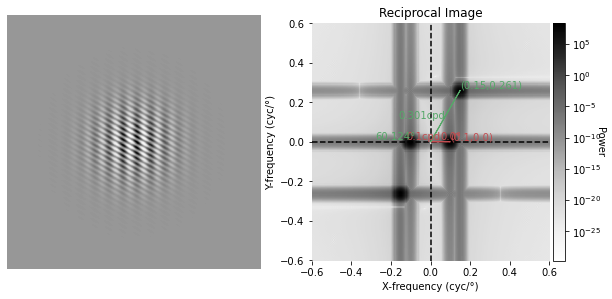

In [8]:
%matplotlib inline
#let's make a plaid, which is the combination of two or more gratings
g1 = Grating(sf=.3, contrast=1/2, orientation=60, window=.1)
g2 = Grating(sf=.1, contrast=1/2, orientation=0, window=.1)
img = g1.img+g2.img
process_reciprocal(img, g1.x, g1.y, num_gratings=2)

## And 3 gratings:

The maxima from the reciprocal image correspond to the x- and y- frequencies of the fundamental grating. We can find them using the find_peaks function from the signal processing library of scipy. 

max x-frequencies=	[ 0.0999  -0.0999  -0.14985  0.14985 -0.0999   0.0999 ]
max y-frequencies=	[ 0.       0.      -0.26085  0.26085  0.17205 -0.17205]
spatial frequency=	[0.0999     0.0999     0.30082843 0.30082843 0.19895028 0.19895028]
orientation=		[   0.          180.         -119.87599269   60.12400731  120.14138555
  -59.85861445]


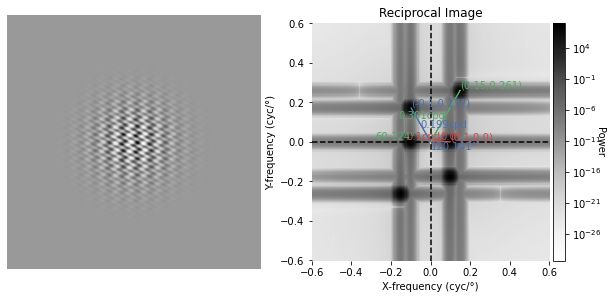

In [9]:
%matplotlib inline
#let's make a plaid, which is the combination of two or more gratings
g1 = Grating(sf=.3, contrast=1/3, orientation=60, window=.1)
g2 = Grating(sf=.1, contrast=1/3, orientation=0, window=.1)
g3 = Grating(sf=.2, contrast=1/3, orientation=120, window=.1)
img = g1.img+g2.img+g3.img
process_reciprocal(img, g1.x, g1.y, num_gratings=3)

## And when all 3 gratings have the same spatial frequency: look familiar?

max x-frequencies=	[-0.2997   0.2997  -0.14985  0.14985  0.14985 -0.14985]
max y-frequencies=	[ 0.       0.      -0.26085 -0.26085  0.26085  0.26085]
spatial frequency=	[0.2997     0.2997     0.30082843 0.30082843 0.30082843 0.30082843]
orientation=		[ 180.            0.         -119.87599269  -60.12400731   60.12400731
  119.87599269]


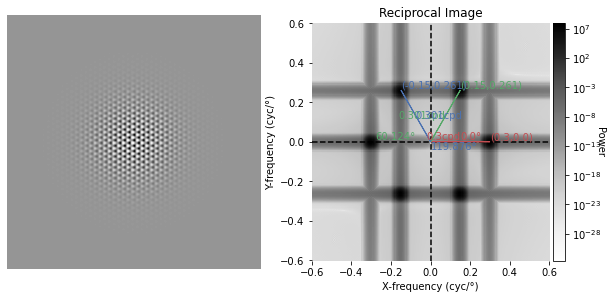

In [10]:
%matplotlib inline
#let's make a plaid, which is the combination of two or more gratings
g1 = Grating(sf=.3, contrast=1/3, orientation=60, window=.1)
g2 = Grating(sf=.3, contrast=1/3, orientation=0, window=.1)
g3 = Grating(sf=.3, contrast=1/3, orientation=120, window=.1)
img = g1.img+g2.img+g3.img
process_reciprocal(img, g1.x, g1.y, num_gratings=3)

## Gratings in the compound eye<img src="https://raw.githubusercontent.com/jpcurrea/eye_tools/main/figs/oda_demo.png" alt="drawing" width="200" align='right'/>
Compound eyes often maximize surface area by following a hexagonal lattice. The ODA works by finding the gratings corresponding to the axes of the ommatidial lattice. First we identify these fundamental gratings in the reciprocal image using the FFT like we did with the generated gratings earlier. Then we zero out any gratings with spatial frequencies sufficiently above (in effect, those further from the center than) the maximum. Using the inverse FFT, we generate a version of the original image without any higher spatial frequencies (smaller details) than the ommatidial diameters. Finally, we use a peak finding algorithm to find the maxima in this smoothed out version of the original image.


### Reciprocal of a compound eye
Let's use the same function as before to look at the reciprocal image of a vinegar fly eye. Notice the repeating hotspots in the reciprocal

max x-frequencies=	[ 0.08049079 -0.08049079  0.          0.         -0.26830264  0.26830264
 -0.34879343  0.34879343]
max y-frequencies=	[ 0.40245396 -0.40245396 -0.02683026  0.02683026  0.26830264 -0.26830264
 -0.16098158  0.16098158]
spatial frequency=	[0.41042412 0.41042412 0.02683026 0.02683026 0.37943723 0.37943723
 0.38415092 0.38415092]
orientation=		[  78.69006753 -101.30993247  -90.           90.          135.
  -45.         -155.22485943   24.77514057]


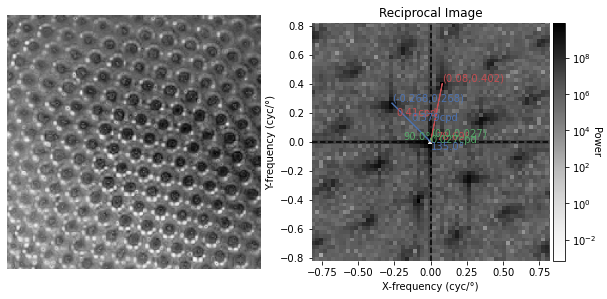

In [11]:
PIXEL_SIZE = (488.84896*2)**-1

img = plt.imread("ommatidia_sample.png")
img = 1 - img[..., 0]
img -= img.mean()
img /= img.std()
xs = np.arange(img.shape[0]) * PIXEL_SIZE
ys = np.arange(img.shape[1]) * PIXEL_SIZE
xs, ys = np.meshgrid(xs, ys)
process_reciprocal(img, xs, ys, num_gratings=4)

But notice there's noise in the background of the reciprocal image that can lead to errors in peak finding. Let's modify the function, adding a stage of 2D cross-correlation to amplify the 2D recurring nature of these maxima.

In [12]:
help(process_reciprocal_smooth)

Help on function process_reciprocal_smooth in module __main__:

process_reciprocal_smooth(img, xvals, yvals, num_gratings=1)
    Process grating information from the 2D autocorrelated reciprocal image.
    
    
    Parameters
    ----------
    img : np.ndarray, shape=(width, height)
        The image to process.
    xvals : array-like, shape=(width)
        The x-values for each column in img.
    yvals : array-like, shape=(height)
        The y-values for each row in img.
    num_gratings : int, default=1
        The number of fundamental frequencies to check for. 
        Half of the peaks to search for.



### Example Ommatidia 
Let's test the new function on a section of a compound eye passed through a guassian window to avoid edge artifacts. Notice how adding the autocorrelation step improved the signal-to-noise ratio of the maxima in the reciprocal image. Still, it 

In [16]:
%matplotlib qt
PIXEL_SIZE = (488.84896*2)**-1
#PIXEL_SIZE = 1

img = plt.imread("ommatidia_sample.png")
img = 1 - img[..., 0]
img -= img.mean()
# apply gaussian window
width, height = img.shape[:2]
gwindow = np.meshgrid(
    gaussian(width, .2*width),
    gaussian(height, .2*height))
gwindow = np.product(gwindow, axis=0)
img *= gwindow

xs = np.arange(img.shape[0]) * PIXEL_SIZE
ys = np.arange(img.shape[1]) * PIXEL_SIZE
xs, ys = np.meshgrid(xs, ys)
reciprocal, xfreqs, yfreqs, results = process_reciprocal_smooth(img, xs, ys, num_gratings=3)

max x-frequencies=	[ 19.98439145 -19.98439145  -4.61178264   4.61178264  15.37260881
 -15.37260881]
max y-frequencies=	[  7.6863044   -7.6863044  -23.05891321  23.05891321 -13.83534792
  13.83534792]
spatial frequency=	[21.41156643 21.41156643 23.51556968 23.51556968 20.68172995 20.68172995]
orientation=		[  21.03751103 -158.96248897 -101.30993247   78.69006753  -41.9872125
  138.0127875 ]


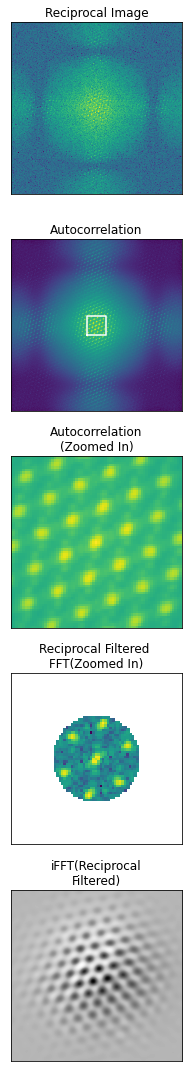

In [17]:
%matplotlib inline
fundamental_freq = results['total_freq'].mean()
dist = 1.25 * fundamental_freq # from above
spatial_freqs = np.sqrt(xfreqs**2 + yfreqs**2)
power = abs(reciprocal)**2
power_cross = signal.correlate(power, power, method='fft', mode='same')
# make figure with 5 subplots
fig, axes = plt.subplots(nrows=5, figsize=(3, 15))
for ax in axes:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
# 1. plot the reciprocal image
axes[0].pcolormesh(xfreqs, yfreqs, power, norm=matplotlib.colors.LogNorm(), shading='auto')
axes[0].set_title('Reciprocal Image')
# 2. plot the smoothed reciprocal image
axes[1].set_title('Autocorrelation')
axes[1].pcolormesh(xfreqs, yfreqs, power_cross, norm=matplotlib.colors.LogNorm(), shading='auto')
d = 2*dist
axes[1].plot([-d, d, d, -d, -d], [-d, -d, d, d, -d], color='w')
# 3. zoom in on smoothed reciprocal image
axes[2].set_title('Autocorrelation\n(Zoomed In)')
axes[2].pcolormesh(xfreqs, yfreqs, power_cross, norm=matplotlib.colors.LogNorm(), shading='auto')
axes[2].set_xlim(-d, d)
axes[2].set_ylim(-d, d)
# 4. plot spatial freqs
filt = spatial_freqs < dist
axes[3].set_title('Reciprocal Filtered \nFFT(Zoomed In)')
axes[3].pcolormesh(xfreqs, yfreqs, power * filt, norm=matplotlib.colors.LogNorm(), shading='auto')
axes[3].set_xlim(-d, d)
axes[3].set_ylim(-d, d)
# 5. plot inverse FFT of filtered reciprocal
new_fft = reciprocal * filt
new_fft = np.fft.fftshift(new_fft)
new_img = np.fft.ifft2(new_fft)
axes[4].set_title('iFFT(Reciprocal\nFiltered)')
axes[4].imshow(new_img.real, cmap='Greys')
plt.tight_layout()

### Measuring ommatidia
We use the fundamental grating frequencies from earlier to generate 1) a frequency filter applied to the FFT of the original image and 2) a minimum distance threshold for peak finding. The iFFT of the Filtered FFT is a smoothed version of the original image without details smaller than the ommatidia. The bright spots in the iFFT(Reciprocal Filtered) align consistently with the ommatidia centers. Finally, we use a peak finding algorithm excluding any distances smaller than  

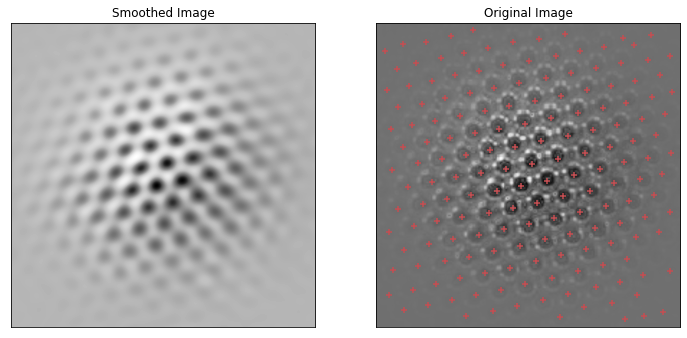

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
smooth_ax, original_ax = axes
# plot the new, smoothed image
smooth_ax.imshow(new_img.real, cmap='Greys')
smooth_ax.set_title('Smoothed Image')
smooth_ax.set_xticks([])
smooth_ax.set_yticks([])
# plot the original image
original_ax.imshow(img, cmap='Greys')
original_ax.set_title('Original Image')
original_ax.set_xticks([])
original_ax.set_xticks([])
original_ax.set_yticks([])
# find peaks with distances substantially greater than the diameter and superimpose on original image
diameter = 1 / fundamental_freq
min_dist = diameter / 3
min_dist /= PIXEL_SIZE
peaks = feature.peak_local_max(new_img.real, min_distance=round(min_dist))
ys, xs = peaks.T
original_ax.scatter(xs, ys, color=red, marker='+')
